# ライブラリ読み込み

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import gc
import pickle
from tqdm import tqdm
%matplotlib inline

import glob
plt.rcParams["font.size"] = 18

In [2]:
import requests
from bs4 import BeautifulSoup
import os
import datetime, pytz
from selenium import webdriver
import lxml.html
from lxml import html
import copy
from sklearn.preprocessing import MultiLabelBinarizer

In [3]:
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [4]:
def set_ylim_zero_start(ax):
    ylim = ax.get_ylim()
    if ax.get_yscale()=='log':
        ylim = [10 ** -1, np.max(ylim)]
    else:
        ylim = [np.min(ylim, 0), np.max(ylim)]
    
    ax.set_ylim(ylim)

In [5]:
def set_sep3(ax, which):
    if which=='x':
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
    elif which=='y':
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
    elif which=='both':
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

In [6]:
mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["font.sans-serif"] = ["Meiryo"]

In [7]:
sns.set_palette('bright')

# 読込

In [8]:
li_files = glob.glob('./youtube_video_info/*')

In [9]:
li_koyori_video_ids = pd.Series(li_files).str.extract(r'./youtube_video_info\\(.*?).pkl')[0].to_list()

In [10]:
df_holostats = pd.read_pickle('./アーカイブ同接推移データ/df_holostats.pkl')
df_koyori = df_holostats[df_holostats['stats_id']=='koyori'].copy()

In [11]:
li_youtube_info = []
for video_id in li_koyori_video_ids:
    with open(f'./youtube_video_info/{video_id}.pkl', 'rb') as f:
        di = pickle.load(f)
        di['video_id'] = video_id
        li_youtube_info.append(di)

# 前処理

In [12]:
def parse_response(response):
    
    di = dict()
    di['video_id'] = response['video_id']
    
    try:
        items = response['items']
        item = items[0]
    except:
        return di
    
    di['kind'] = item['kind']
    di['etag'] = item['etag']
    try:
        di['scheduled_start_datetime'] = item['liveStreamingDetails']['scheduledStartTime']
        di['start_datetime'] = item['liveStreamingDetails']['actualStartTime']
        di['end_datetime'] = item['liveStreamingDetails']['actualEndTime']
    except:
        pass
    di['published_datetime'] = item['snippet']['publishedAt']
    di['duration'] = item['contentDetails']['duration']
    di['title'] = item['snippet']['title']

    try:
        di['view_count'] = item['statistics']['viewCount']
    except:
        pass
    di['like_count'] = item['statistics']['likeCount']
    di['favorite_count'] = item['statistics']['favoriteCount']
    try:
        di['comment_count'] = item['statistics']['commentCount']
    except:
        pass
    
    di['tags'] = item['snippet']['tags']
    try:
        di['topic_categories'] = item['topicDetails']['topicCategories']
    except:
        di['topic_categories'] = []
    
    di['channel_id'] = item['snippet']['channelId']
    di['category_id'] = item['snippet']['categoryId']

    di['content_rating'] = item['contentDetails']['contentRating']
    di['caption'] = item['contentDetails']['caption']
    di['licensed_content'] = item['contentDetails']['licensedContent']
    di['channel_title'] = item['snippet']['channelTitle']
    di['thumbnail_url'] = f'https://img.youtube.com/vi/{di["video_id"]}/maxresdefault.jpg'
    di['live_broadcast_content'] = item['snippet']['liveBroadcastContent']
    di['description'] = item['snippet']['description']
    
    try:
        di['defaultAudioLanguage'] = item['snippet']['defaultAudioLanguage']
    except:
        pass
    di['localized_title'] = item['snippet']['localized']['title']
    di['localized_description'] = item['snippet']['localized']['description']
    return di

## データフレーム化

In [13]:
# for y2info in li_youtube_info:
#     parse_response(y2info)

In [14]:
li_parsed_youtube_info = [parse_response(y2info) for y2info in li_youtube_info]
df_youtube = pd.DataFrame(li_parsed_youtube_info)

欠損レコード

In [15]:
li_dropped_video_ids = df_youtube[df_youtube['etag'].isnull()]['video_id'].to_list()
li_dropped_video_ids

['UJf32yqwPHc']

In [16]:
df_youtube = df_youtube[df_youtube['etag'].notnull()].copy().reset_index(drop=True)

## 型変換

In [17]:
df_youtube['scheduled_start_datetime'] = pd.to_datetime(df_youtube['scheduled_start_datetime'], utc=True)
df_youtube['start_datetime'] = pd.to_datetime(df_youtube['start_datetime'], utc=True)
df_youtube['end_datetime'] = pd.to_datetime(df_youtube['end_datetime'], utc=True)
df_youtube['published_datetime'] = pd.to_datetime(df_youtube['published_datetime'], utc=True)
df_youtube['scheduled_start_datetime'] = df_youtube['scheduled_start_datetime'].dt.tz_convert('Asia/Tokyo').dt.tz_localize(None)
df_youtube['start_datetime'] = df_youtube['start_datetime'].dt.tz_convert('Asia/Tokyo').dt.tz_localize(None)
df_youtube['end_datetime'] = df_youtube['end_datetime'].dt.tz_convert('Asia/Tokyo').dt.tz_localize(None)
df_youtube['published_datetime'] = df_youtube['published_datetime'].dt.tz_convert('Asia/Tokyo').dt.tz_localize(None)

In [18]:
df_youtube['duration'] = (df_youtube['end_datetime'] - df_youtube['start_datetime']).dt.seconds
df_youtube['view_count'] = df_youtube['view_count'].astype(float)
df_youtube['like_count'] = df_youtube['like_count'].astype(float)
df_youtube['favorite_count'] = df_youtube['favorite_count'].astype(float)
df_youtube['comment_count'] = df_youtube['comment_count'].astype(float)

In [19]:
df_youtube['year'] = df_youtube['start_datetime'].dt.year
df_youtube['month'] = df_youtube['start_datetime'].dt.month
df_youtube['day'] = df_youtube['start_datetime'].dt.day
df_youtube['hour'] = df_youtube['start_datetime'].dt.hour
df_youtube['year_month'] = pd.to_datetime(df_youtube['start_datetime']).dt.to_period('M')

In [20]:
with pd.option_context('display.max_colwidth', 30):
    display(df_youtube.head(1))

,video_id,kind,etag,scheduled_start_datetime,start_datetime,end_datetime,published_datetime,duration,title,view_count,like_count,favorite_count,comment_count,tags,topic_categories,channel_id,category_id,content_rating,caption,licensed_content,channel_title,thumbnail_url,live_broadcast_content,description,defaultAudioLanguage,localized_title,localized_description,year,month,day,hour,year_month
0,-bEB2Utn3P4,youtube#video,8B37K6xVnzL5H4MfAk563L25upY,2022-04-28 22:00:00,2022-04-28 22:00:39,2022-04-29 00:08:50,2022-04-29 00:20:08,7691.0,【Surgeon Simulator2】#KoLuC...,76667.0,7123.0,0.0,109.0,"[hololive, ホロライブ, 6期生, hol...",[https://en.wikipedia.org/...,UC6eWCld0KwmyHFbAqK3V-Rw,20,{},false,True,Koyori ch. 博衣こより - holoX -,https://img.youtube.com/vi...,none,前回3人で力を合わせて手術に挑んだKoLuC！何やら...,ja,【Surgeon Simulator2】#KoLuC...,前回3人で力を合わせて手術に挑んだKoLuC！何やら...,2022.0,4.0,28.0,22.0,2022-04


In [21]:
mlb = MultiLabelBinarizer()
df_video_tags = pd.concat(
    [
        df_youtube[['video_id']],
        pd.DataFrame(mlb.fit_transform(df_youtube['tags']),columns=mlb.classes_, index=df_youtube.index)
    ],axis=1
)

In [22]:
df_video_tags.head()

,video_id,13章,2022,2人コラボ,2人プレイ,3rd Live Link Your Wish,3か月記念,3期生,6期生,ARK,ASMR,ASMRコラボ,AZKi,AmongUs,April Fool,AsaKoyo,B'z,Biohazard,Birthday,Butter-Fly,CCさくら,COVER,Calliope,Ceres Fauna,Chilla's art,Core Keeper,CryBaby,DAY1,DCG,DDLC,DLC,DQM1,DR-07,Doki Doki Literature Club,Doki Doki Literature Club!,ED,ED回収,ELDEN RING,EN,Earth DefenceForce,Earth DefenceForce 5,English,English Stream,English stream,Eve,FREETALK,Freetalk,GTA,GTA5,GTAⅤ,Game stream,Gartic Phone,Gawr Gura,Getting Over It,Hakos Baelz,Hardcore,ID,Ib,J-POP,JumpKing,KoLuC,LiSA,Link Your Wish,Live,Live同時視聴,Lost Island,Lost my music,Minecraft,Mori,Morning,Myth,NARUTO,NEEDY GIRL OVERDOSE,NieR,NieR automata,NieR replicant,Nintendo,PON,PS4,PS5,Papers Please,Passpartout,Phasmophobia,Pokemon,P丸様。,RFA,RP,RPG,RPGツクール,Raft,Reddit,RingFitAdventure,SUPER BUNNY MAN,Shadow Corridor,Shadowverse,Short,Shorts,Shorts動画,Short動画,Sing,...,獅白ぼたん,王都,生歌,生神もんざえもん,生誕祭,生配信,癒月ちょこ,発売日,白上フブキ,白銀ノエル,百鬼あやめ,相談室,真島,真島のアニキ,真島吾朗,石川さゆり,神ゲー,私アイドル宣言,秘密結社holoX,空気読み,童謡,経営ゲーム,結果発表,綿棒,縛りプレイ,罰ゲーム,美術館,耐久,耐久歌枠,耐久配信,耳かき,耳ふー,脱出ゲーム,腹筋,苦手,英語,英語勉強,英語配信,落ちる,血海戦線,裏ボス,見守り,見守りホラー,視聴者参加型,視聴者対戦,角巻わため,記念日,誕生日,語学,語学勉強,謎解き,負けたら,質問,赤ちゃん,赤井はあと,車,転生,軽い運動,追加DLC,速すぎるRPG,運動,運転,邪神ころね,都道府県,酒,重大告知,重大発表,野球,鏡音リン,開封,開封実況,阿鼻叫喚,限定,限定配信,集計結果,雑談,雑談配信,雑魚,雑魚杯,雨宮天,雪花ラミィ,青鬼,頭の体操,頭脳,頭脳ゲーム,風真いろは,飲み会,飲む,飲酒,鬼滅の刃,鬼滅の刃無限列車編,鬼畜ゲー,魔女の家,鮫,鷹嶺ルイ,麻雀,龍が如く,龍が如く極,龍が如く０,Ｔｗｉｔｔｅｒ
0,-bEB2Utn3P4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,-d02ZBhw8v8,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,-FkLkXLwnKM,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,-pHnmv7rBc8,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,-rrqtt8gabY,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [23]:
for i in range(len(df_youtube)):
    video_id = df_youtube.loc[i,'video_id']
    title = df_youtube.loc[i,'title']
    # print(video_id, title)
    # print(df_youtube.loc[i,'tags'])
    # print()

In [24]:
df_youtube['duration'] = (df_youtube['end_datetime'] - df_youtube['start_datetime']).dt.seconds
df_youtube['view_count'] = df_youtube['view_count'].astype(float)
df_youtube['like_count'] = df_youtube['like_count'].astype(float)
df_youtube['favorite_count'] = df_youtube['favorite_count'].astype(float)
df_youtube['comment_count'] = df_youtube['comment_count'].astype(float)

## カテゴリ作成

In [25]:
df_for_agg = df_youtube.copy()

df_for_agg[['live_category', 'live_category_sub']] = df_for_agg['title'].str.extract('.*?【(.*?)】.*?【(.*?)】')
df_for_agg.loc[df_for_agg['video_id']=='cU4oDDLhGcc', ['live_category', 'live_category_sub']] = ['リスナーアンケート', '【博衣こより/ホロライブ】']

df_for_agg = df_for_agg[
    ['video_id', 'scheduled_start_datetime', 'start_datetime', 'end_datetime', 'duration', 'title', 'live_category', 'live_category_sub', 'year', 'month', 'day', 'year_month', 'view_count', 'like_count', 'favorite_count', 'comment_count']
].copy()

# 歌ってみた除外
df_for_agg = df_for_agg[df_for_agg['live_category_sub'].notnull()].copy()
df_for_agg = df_for_agg[~df_for_agg['video_id'].isin(['pmFbqPRFz_8', 'nCyKjz-ie3c'])].copy()
df_for_agg = df_for_agg[df_for_agg['start_datetime'].notnull()].copy()

In [26]:
df_for_agg['live_category'] = df_for_agg['live_category'].str.replace(r'朝こよ#(\d+)', '朝こよ', regex=True)
df_for_agg['live_category'] = df_for_agg['live_category'].str.replace(r'#朝こよ', '朝こよ')

In [27]:
df_for_agg.loc[
    (df_for_agg['live_category']=='初晩酌配信')
    | (df_for_agg['live_category']=='立体音響晩酌')
    | (df_for_agg['live_category']=='晩酌雑談')
    | (df_for_agg['live_category']=='初ソロ雑談')
    | (df_for_agg['live_category']=='SuperChat御礼')
    | (df_for_agg['live_category']=='朝活')
    | (df_for_agg['live_category']=='TALK')
    | (df_for_agg['live_category']=='初配信振り返り')
    | (df_for_agg['live_category']=='朝こよ アフタートーク')
    | (df_for_agg['video_id']=='FBvgGNFSGUE')
    ,'live_category'] = '雑談'

In [28]:
df_for_agg.loc[
    (df_for_agg['live_category']=='Talk&Singing')
    | (df_for_agg['live_category']=='#ホロクリスマス歌枠リレー')
    | (df_for_agg['live_category']=='耐久歌枠')
    | (df_for_agg['live_category']=='Singing')
    | (df_for_agg['live_category']=='Sing')
    | (df_for_agg['video_id']=='Ed0pkQSTfDY')
    | (df_for_agg['video_id']=='zF6msQLzthg')

    ,'live_category'] = '歌枠'

In [29]:
df_for_agg.loc[
    # (df_for_agg['live_category']=='ASMRコラボ')
    (df_for_agg['video_id']=='uiUC_lW1z30')
    ,'live_category'] = 'ASMR'

In [30]:
df_for_agg.loc[
    (df_for_agg['live_category']=='アンケート')
    ,'live_category'] = 'リスナーアンケート'

In [31]:
df_for_agg.loc[
    (df_for_agg['live_category']=='AmongUs')
    | (df_for_agg['live_category']=='#ホロお題人狼')
    | (df_for_agg['live_category']=='#ホロシチュエーションAmongUs')
    | (df_for_agg['live_category']=='#ほろ酔いAmongUs')
    ,'live_category'] = 'AmongUs'

In [32]:
df_for_agg.loc[
    (df_for_agg['video_id']=='T-4jCHQQO2s')
    ,'live_category'] = '南極地点X'

In [33]:
df_for_agg.loc[
    (df_for_agg['live_category']=='#ホロGarticPhone')
    ,'live_category'] = 'Gartic Phone'

In [34]:
df_for_agg.loc[
    (df_for_agg['live_category']=='ゲリラARK')
    | (df_for_agg['live_category']=='#ホロARK')
    ,'live_category'] = 'ARK'

In [35]:
df_for_agg.loc[
    (df_for_agg['video_id']=='xOQF27v15i8')
    ,'live_category'] = '占いコラボ'

In [36]:
df_for_agg.loc[
    (df_for_agg['live_category']=='メン限同時視聴')
    | (df_for_agg['video_id']=='zYnbLBSv_QY')
    ,'live_category'] = 'メンバーシップ限定'

In [37]:
df_for_agg.loc[
    (df_for_agg['live_category']=='ポケカ開封/カメラ')
    ,'live_category'] = 'ポケカ開封'

In [38]:
df_for_agg.loc[
    (df_for_agg['live_category']=='ドラゴンの島/ネタバレあり')
    ,'live_category'] = 'ドラゴンの島'

In [39]:
df_for_agg.loc[
    (df_for_agg['live_category']=='English')
    | (df_for_agg['live_category']=='duolingo')
    ,'live_category'] = '英語勉強'

In [40]:
df_for_agg.loc[
    (df_for_agg['live_category']=='#ホロお正月CUP2022')
    ,'live_category'] = 'マリオカート8DX'

In [41]:
df_for_agg.loc[
    (df_for_agg['live_category']=='#つながるホロライブDAY1')
    ,'live_category'] = 'ライブ同時視聴'

In [42]:
df_for_agg.loc[
    (df_for_agg['live_category']=='#ロリこより')
    ,'live_category'] = 'ロリこより'

In [43]:
df_for_agg.loc[
    (df_for_agg['live_category']=='#hololiveERROR')
    ,'live_category'] = 'hololiveERROR'

In [44]:
df_for_agg.loc[
    (df_for_agg['live_category']=='DQM')
    ,'live_category'] = 'ドラゴンクエストモンスターズ'

In [45]:
df_for_agg[df_for_agg['title'].str.contains('cover')]#['live_category'].value_counts()

,video_id,scheduled_start_datetime,start_datetime,end_datetime,duration,title,live_category,live_category_sub,year,month,day,year_month,view_count,like_count,favorite_count,comment_count


In [51]:
# df_for_agg[df_for_agg.isnull().any(axis=1)]

In [52]:
df_for_agg.isnull().sum()

video_id                     0
scheduled_start_datetime     0
start_datetime               0
end_datetime                 0
duration                     0
title                        0
live_category                0
live_category_sub            0
year                         0
month                        0
day                          0
year_month                   0
view_count                  11
like_count                   0
favorite_count               0
comment_count                1
dtype: int64

In [54]:
df_for_agg['year'] = df_for_agg['year'].astype(int)
df_for_agg['month'] = df_for_agg['month'].astype(int)
df_for_agg['day'] = df_for_agg['day'].astype(int)

In [55]:
df_for_agg['live_category'].value_counts()

朝こよ                                 50
雑談                                  23
ELDEN RING                          19
ARK                                 18
歌枠                                  17
マリオカート8DX                           13
Minecraft                           11
メンバーシップ限定                           11
ポケモンBDSP                            10
パワプロ2022                             7
英語勉強                                 7
Getting Over It                      7
ASMR                                 6
ドラゴンクエストモンスターズ                       6
AmongUs                              5
龍が如く極                                5
ポケカ開封                                5
Phasmophobia                         4
Vampire Survivors                    4
ドラゴンの島                               4
Pokémon LEGENDS アルセウス                3
BIOHAZARD RE:2                       3
リングフィットアドベンチャー                       3
Papers, Please                       3
Raft                                 3
JumpKing                 

In [56]:
df_youtube.sort_values('start_datetime').tail(15)

,video_id,kind,etag,scheduled_start_datetime,start_datetime,end_datetime,published_datetime,duration,title,view_count,like_count,favorite_count,comment_count,tags,topic_categories,channel_id,category_id,content_rating,caption,licensed_content,channel_title,thumbnail_url,live_broadcast_content,description,defaultAudioLanguage,localized_title,localized_description,year,month,day,hour,year_month
263,TD8jPxQtrJI,youtube#video,sPrTFu_TtfT4Um4BDtsMMIePGN4,2022-05-20 08:00:00,2022-05-20 08:05:03,2022-05-20 10:12:45,2022-05-20 10:20:10,7662.0,【朝こよ#49 アフタートーク】雑談＆SuperChat御礼！【博衣こより/ホロライブ】,36807.0,4136.0,0.0,94.0,"[hololive, ホロライブ, 6期生, holoX, 博衣こより, 生配信, 朝配信,...",[https://en.wikipedia.org/wiki/Video_game_cult...,UC6eWCld0KwmyHFbAqK3V-Rw,24,{},false,True,Koyori ch. 博衣こより - holoX -,https://img.youtube.com/vi/TD8jPxQtrJI/maxresd...,none,🌟朝こよ！#49本編はこちら→ https://youtu.be/Ba9_eTiSdrI 🌟...,ja,【朝こよ#49 アフタートーク】雑談＆SuperChat御礼！【博衣こより/ホロライブ】,🌟朝こよ！#49本編はこちら→ https://youtu.be/Ba9_eTiSdrI 🌟...,2022.0,5.0,20.0,8.0,2022-05
28,3aBMQt0VvLU,youtube#video,wlSK5OfUksRQNzGW6BLY7jUFljs,2022-05-20 19:00:00,2022-05-20 19:02:39,2022-05-20 22:11:19,2022-05-20 22:48:00,11320.0,【ELDEN RING】最終回！マレニアを絶対に倒したい！からの全ボスへ挑戦！！【博衣こより...,123931.0,8097.0,0.0,168.0,"[hololive, ホロライブ, 6期生, holoX, 博衣こより, 生配信, ゲーム実...",[https://en.wikipedia.org/wiki/Action-adventur...,UC6eWCld0KwmyHFbAqK3V-Rw,20,{},false,True,Koyori ch. 博衣こより - holoX -,https://img.youtube.com/vi/3aBMQt0VvLU/maxresd...,none,ラスボスより強いと言われている「マレニア」…この敵を倒して、こよデンリング大団円となるのだ！...,ja,【ELDEN RING】最終回！マレニアを絶対に倒したい！からの全ボスへ挑戦！！【博衣こより...,ラスボスより強いと言われている「マレニア」…この敵を倒して、こよデンリング大団円となるのだ！...,2022.0,5.0,20.0,19.0,2022-05
143,hhGES-MRR2U,youtube#video,Cx30zkmRGh6y2daSQcNNz4TND7A,2022-05-21 10:00:00,2022-05-21 10:02:06,2022-05-21 16:45:14,2022-05-21 17:26:36,24188.0,#2【龍が如く0】完全初見！真島のアニキ編から！(3章～)【博衣こより/ホロライブ】※ネタバレあり,116075.0,7294.0,0.0,125.0,"[hololive, ホロライブ, 6期生, holoX, 博衣こより, 生配信, 龍が如く...",[https://en.wikipedia.org/wiki/Action-adventur...,UC6eWCld0KwmyHFbAqK3V-Rw,20,{},false,True,Koyori ch. 博衣こより - holoX -,https://img.youtube.com/vi/hhGES-MRR2U/maxresd...,none,「龍が如く極」でシリーズ完全初見を楽しんだこより。神作0を楽しみ中！真島のアニキ編楽しみだ～...,ja,#2【龍が如く0】完全初見！真島のアニキ編から！(3章～)【博衣こより/ホロライブ】※ネタバレあり,「龍が如く極」でシリーズ完全初見を楽しんだこより。神作0を楽しみ中！真島のアニキ編楽しみだ～...,2022.0,5.0,21.0,10.0,2022-05
314,ZriR7nKXjP0,youtube#video,0EBVO7Rp8ZIJmvZmvbYt2gDuRqg,2022-05-21 19:00:00,2022-05-21 19:00:33,2022-05-21 20:08:05,2022-05-21 20:26:59,4052.0,【マリオカート8DX】負けたら腹筋！ガチバトル！【博衣こより視点/ホロライブ】,69498.0,6328.0,0.0,137.0,"[hololive, ホロライブ, 6期生, holoX, 博衣こより, 生配信, マリオカ...",[https://en.wikipedia.org/wiki/Racing_video_ga...,UC6eWCld0KwmyHFbAqK3V-Rw,20,{},false,True,Koyori ch. 博衣こより - holoX -,https://img.youtube.com/vi/ZriR7nKXjP0/maxresd...,none,#ホロ腹筋マリカ ひさびさのマリオカートだあああ！！！腹筋は強いからお任せください✌\nメン...,ja,【マリオカート8DX】負けたら腹筋！ガチバトル！【博衣こより視点/ホロライブ】,#ホロ腹筋マリカ ひさびさのマリオカートだあああ！！！腹筋は強いからお任せください✌\nメン...,2022.0,5.0,21.0,19.0,2022-05
48,8Cagup2qBI8,youtube#video,Bt_LF1lu92kLVOedfNC5m1X_IXU,2022-05-22 10:00:00,2022-05-22 10:00:57,2022-05-22 17:56:06,2022-05-22 18:46:39,28509.0,【パワプロ2022】ホロメンONLY栄冠ナイン！3年目春の甲子園から4年目へ！夏の甲子園を目...,230422.0,9935.0,0.0,209.0,"[hololive, ホロライブ, 6期生, holoX, 博衣こより, 生配信, パワプロ...","[https://en.wikipedia.org/wiki/Entertainment, ...",UC6eWCld0KwmyHFbAqK3V-Rw,20,{},false,True,Koyori ch. 博衣こより - holoX -,https://img.youtube.com/vi/8Cagup2qBI8/maxresd...,none,ホロライブメンバーで目指す甲子園！栄冠ナイン！2年目は春の甲子園に出場！しかし、3年目は夏の...,ja,【パワプロ2022】ホロメンONLY栄冠ナイン！3年目春の甲子園から4年目へ！夏の甲子園を目...,ホロライブメンバーで目指す甲子園！栄冠ナイン！2年目は春の甲子園に出場！しかし、3年目は夏の...,2022.0,5.0,22.0,10.0,2022-05
296,xMD7voFH4ZU,youtube#video,ny2GfRTDRklS2581zBNsjLqE_bk,2022-05-23 22:30:00,2022-05-23 22:31:20,2022-05-24 01:01:29,2022-05-24 01:19:53,9009.0,【晩酌雑談】ミニオリ曲とかお話したいこといっぱい！～梅酒を添えて～【博衣こより/ホロライブ】,60464.0,6702.0,0.0,109.0,"[hololive, ホロライブ, 6期生, holoX, 博衣こより, 生配信, ラジオ,...","[https://en.wikipedia.org/wiki/Entertainment, ...",UC6eWCld0KwmyHFbAqK3V-Rw,24,{},false,True,Koyori ch. 博衣こより - holoX -,https://img.youtube.com/vi/xMD7voFH4ZU/maxresd...,none,ラプちゃんがオフコラボの時にお土産で持ってきてくれた梅酒を添えて、晩酌雑談するよ～！！\n

In [57]:
df_for_agg.to_pickle('./KOYORI/df_for_agg.pkl')

## 集計

In [58]:
from itertools import product

In [59]:
# with pd.option_context('display.max_colwidth', 10):
#     display(df_for_agg.head())

In [60]:
#後で使うカラーをまとめて先に指定しておく（自分が好きな色を指定）
c_cycle=("#f1c40f", "#3498db","#ff8c8d","#51a62d",
         "#34495e","#446cb3","#d24d57","#27ae60",
         "#663399","#f7ca18","#bdc3c7","#2c3e50","#d35400",
         "#9b59b6","#ecf0f1","#ecef57","#9a9a00","#8a6b0e")

In [61]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image
import time

In [62]:
df_agg = df_for_agg.groupby(['year_month', 'live_category'])[['duration']].agg(['sum', 'median']).reset_index()
df_agg.columns = ['year-month', 'category', 'total_seconds', 'median_seconds']
df_agg['total_hours'] = df_agg['total_seconds'] / 3600

In [63]:
df_left = pd.DataFrame(
    list(
        product(
            df_agg[['year-month']].drop_duplicates()['year-month'], 
            df_agg['category'].sort_values().unique()
        )
    ),
    columns=['year-month', 'category']
)

In [64]:
df_agg_merged = pd.merge(
    df_left,
    df_agg,
    on=['year-month', 'category'],
    how='left'
).fillna(0)

In [65]:
ymlist = sorted(df_agg_merged['year-month'].unique())

In [66]:
import matplotlib.pyplot as plt
import base64
from io import BytesIO
import matplotlib.pyplot as plt
from IPython.display import HTML
from jinja2 import Template
import matplotlib.cm as cm

In [67]:
colors = [rgb for idx, (color, rgb) in enumerate(mpl.colors.CSS4_COLORS.items())][::-1]
c_cycles = {title:colors[i] for i,title in enumerate(df_for_agg['live_category'].unique())}

In [68]:
# c_cycles['Apex Legends'] = '#0000FF'
c_cycles['朝こよ'] = '#FFFF00'
c_cycles['Minecraft'] = '#FF0000'
c_cycles['歌枠'] = '#00FF00'
c_cycles['雑談'] = '#777777'

# #c_cycles['Thief Simulator'] = '#000055'
c_cycles['ELDEN RING'] = '#888800'
c_cycles['メンバーシップ限定'] = '#88FF88'
# c_cycles['ウマ娘'] = '#555500'

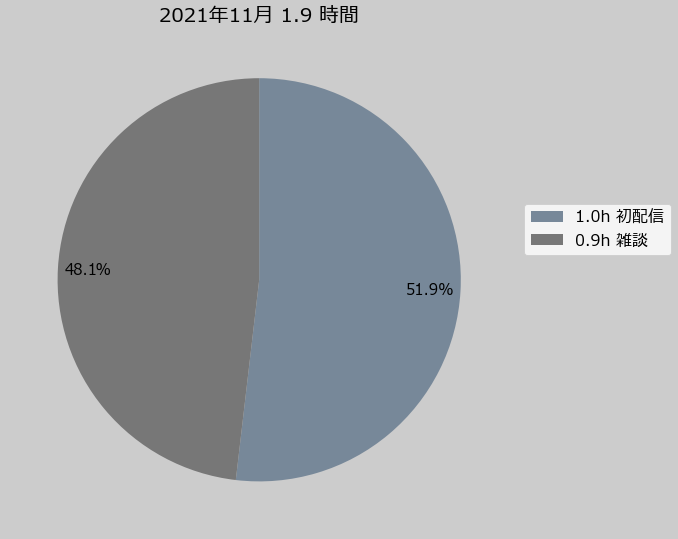

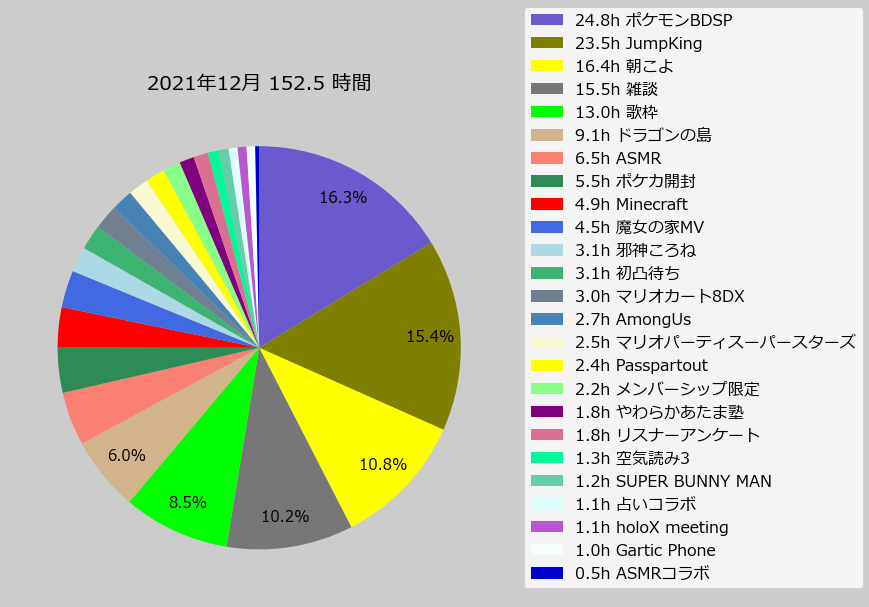

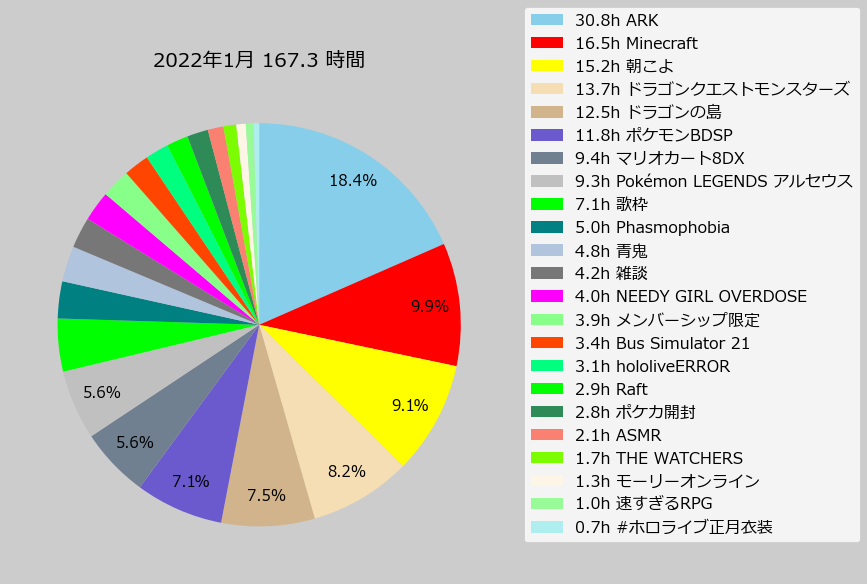

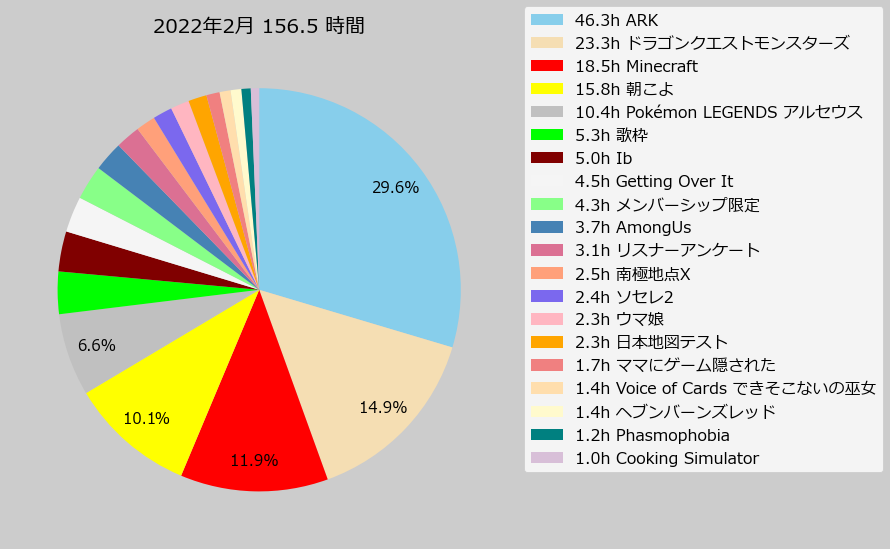

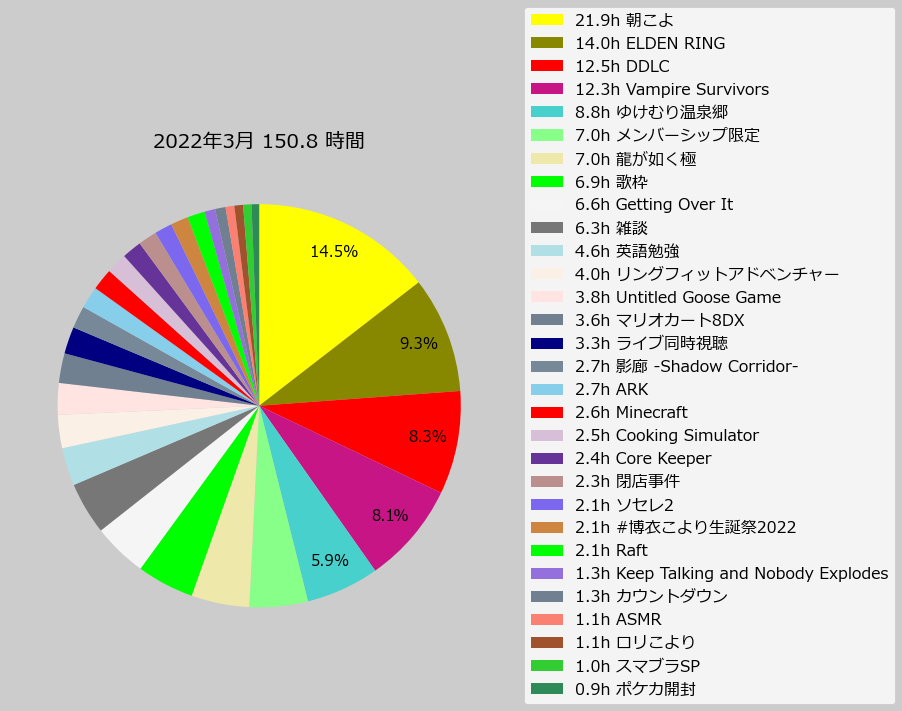

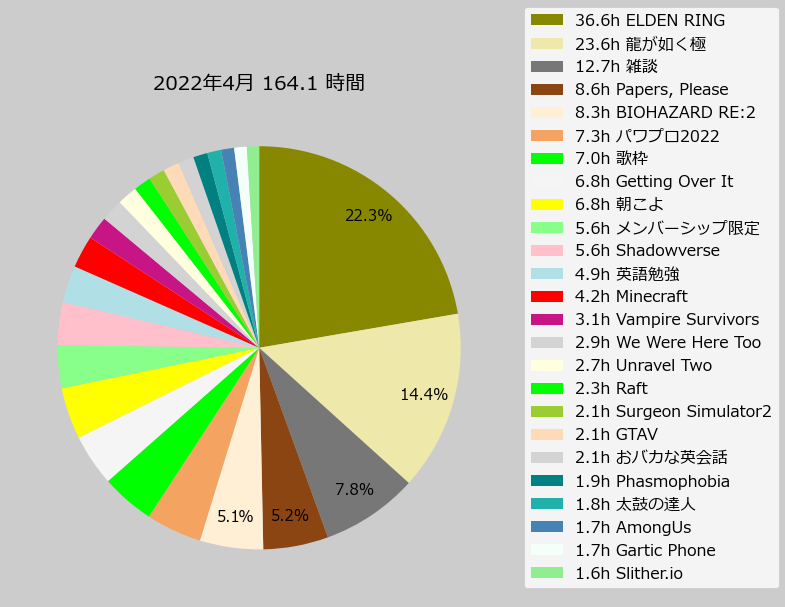

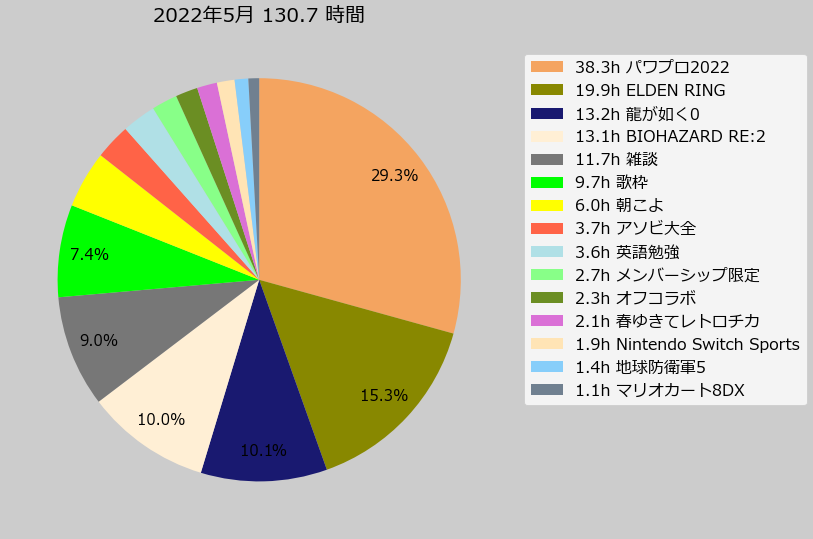

In [69]:
# images = []
# images = { vnuma_id : (np.asarray(Image.open(f'./channel_images/{vnuma_id}.jpg').resize((180,180)))) for vnuma_id in df2021['vnuma_id']}  

temp_figs = []

for i, ym in enumerate(ymlist):
    plt.ioff()  # 対話的操作をオフ
    fig, ax = plt.subplots(1, 1, figsize=(11,5))
    plt.subplots_adjust(wspace=0.1)
    plt.subplots_adjust(hspace=0.1)
    diff = 0.2
    plt.subplots_adjust(left=diff, right=1.8-diff, bottom=diff, top=1.8-diff)

    col=cm.Spectral([0.2, 0.4])

    # holomen
    df_sub = df_agg_merged[
        df_agg_merged['year-month']==ym
    ].copy()
    
    df_sub = df_sub[df_sub['total_hours']>0].sort_values('total_hours', ascending=False)
    
    df_sub_raw = df_for_agg[
        df_for_agg['year_month']==ym
    ]
    total_hours = float(df_sub['total_hours'].sum())
    
    color_mapping = [c_cycles[title] for title in df_sub['category'].unique()]
    labels = [f'{h:.1f}h {t}' for t, h in zip(df_sub['category'], df_sub['total_hours'])]
    labels_pie = [f'{t}' for t, hp in zip(df_sub['category'], (df_sub['total_hours'] / df_sub['total_hours'].sum()))]
    
    ax.pie(
        df_sub['total_hours'],
        counterclock=False, 
        autopct=lambda p: '{:.1f}%'.format(p) if p >= 5 else '', 
        startangle=90,
        pctdistance=0.85,
        colors=color_mapping,
        textprops={'size': 'small'},
    )
    ax.legend(labels,fancybox=True,loc='center left',bbox_to_anchor=(1.01,0.6), fontsize=16)

#     vnuma_id = df_sub_raw['vnuma_id'].unique()[0]
#     im = OffsetImage(images[vnuma_id], zoom=0.3, alpha=1)
#     x, y = ax.get_position().bounds[:2]
    
#     ab = AnnotationBbox(im, (0,0.83), xycoords='axes fraction', frameon=False)
#     ax.add_artist(ab)
    
    ax.set_title(f'{ym.year}年{ym.month}月 {total_hours:.1f} 時間', fontdict={'fontsize':20})
    fig.patch.set_facecolor((0.8, 0.8, .8))
    
    
    for i in np.arange(i, 7*5, dtype=int):
        ax.axis('off')
    
    #plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
    #plt.show()
    
    bytes_data = BytesIO()
    # fig.savefig(bytes_data, format='png', bbox_inches='tight', pad_inches=0)
    fig.savefig(bytes_data, format='png', bbox_inches='tight', pad_inches=0)
    png_data = base64.b64encode(bytes_data.getvalue()).decode()
    
    temp_figs.append(png_data)
    plt.show()
#fig.savefig('2021年1月 配信内訳.png',bbox_inches='tight',pad_inches=0.05)

,
,
,

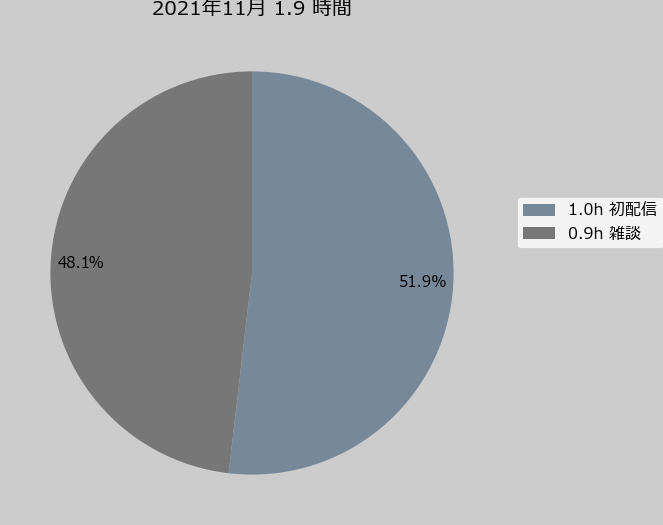
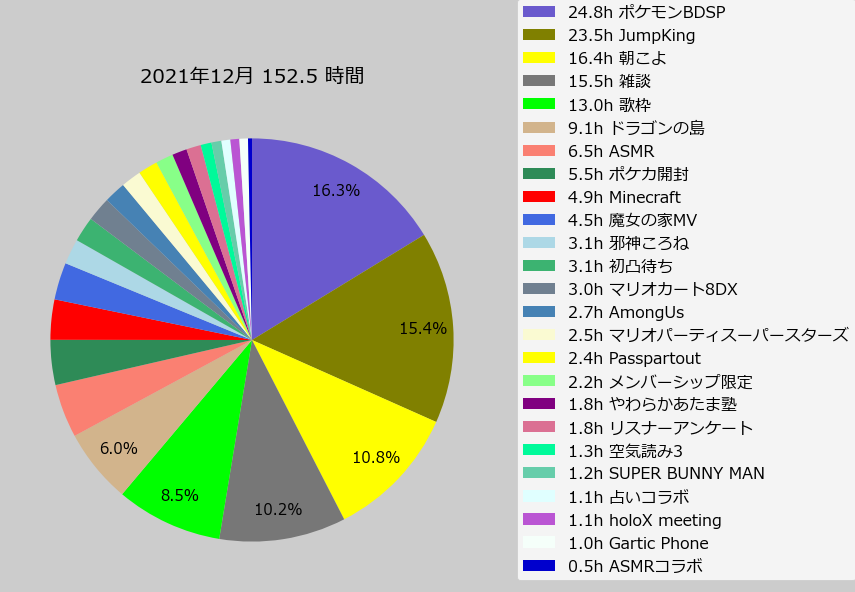
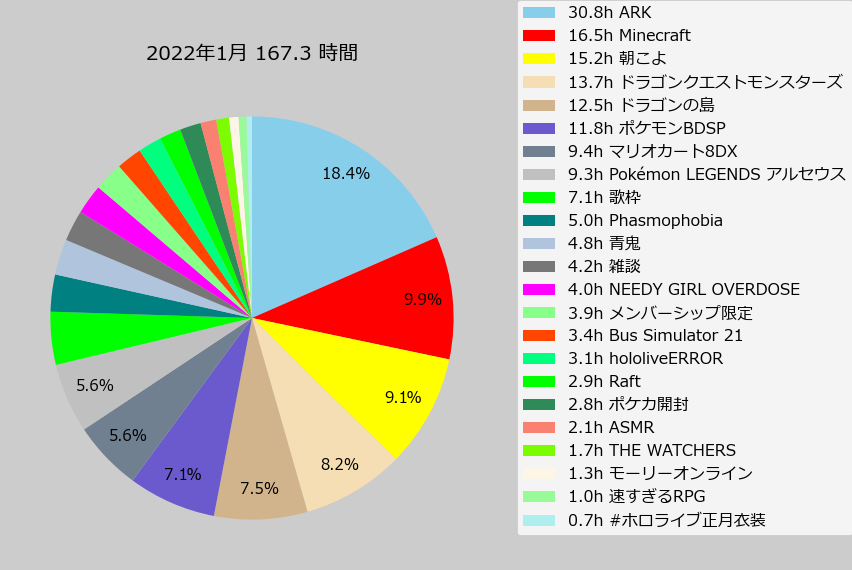
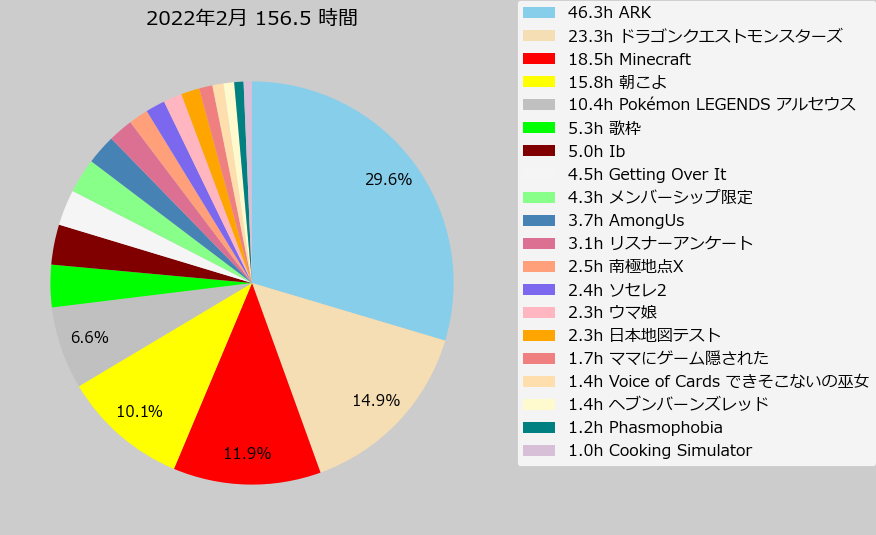
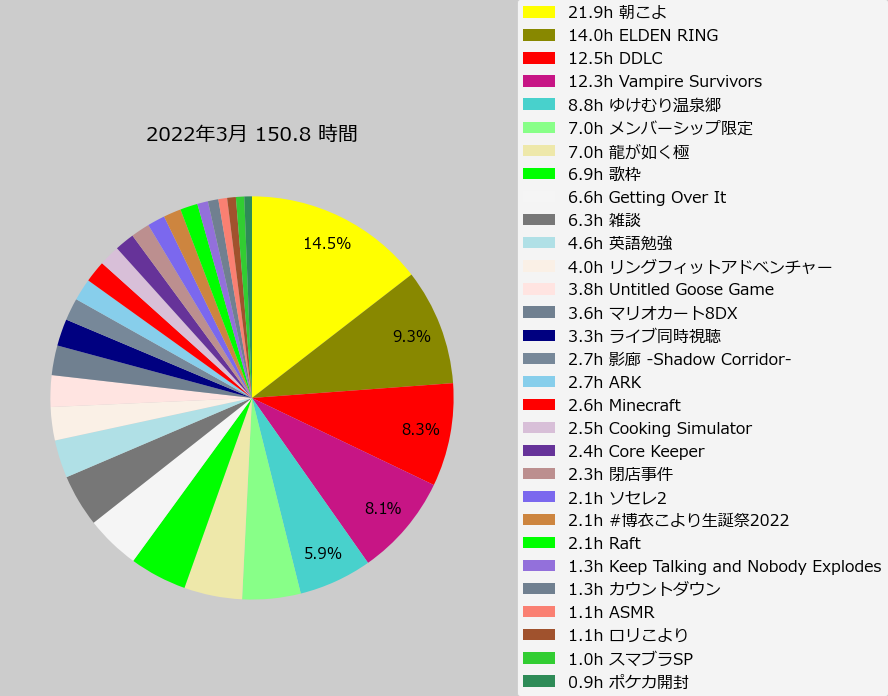
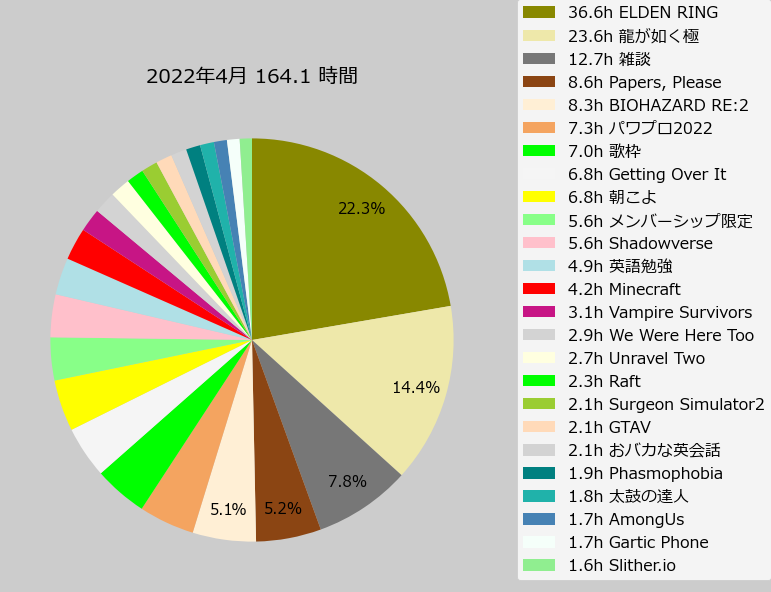

In [70]:
# HTML出力
html_tpl = """
<body bgcolor="#cccccc" text="#cccccc">
<table>
  <tr>
    <td><img src="data:image/png;base64,{{ png_data1 }}" /></td>
    <td><img src="data:image/png;base64,{{ png_data2 }}" /></td>
  </tr>
  <tr>
    <td><img src="data:image/png;base64,{{ png_data3 }}" /></td>
    <td><img src="data:image/png;base64,{{ png_data4 }}" /></td>
  </tr>
  <tr>
    <td><img src="data:image/png;base64,{{ png_data5 }}" /></td>
    <td><img src="data:image/png;base64,{{ png_data6 }}" /></td>
  </tr>


</table>
</body>
"""
tpl = Template(html_tpl)
html_text = tpl.render({f'png_data{i+1}':fig for i,fig in enumerate(temp_figs)})

HTML(html_text)

In [71]:
with open('render.html', 'w') as f:
    f.writelines(html_text)

In [68]:
df_merged = pd.merge(
    df_for_agg.sort_values('view_count', ascending=False),
    df_holostats[df_holostats['stats_id']=='koyori'][['video_id', 'avg_viewers', 'max_viewers']],
    on='video_id',
    how='left'
)

In [70]:
df_merged = df_merged[df_merged['max_viewers'].notnull()].copy()

In [71]:
df_merged['avg_avg_viewers'] = df_merged.groupby('live_category')['avg_viewers'].transform(np.mean)
df_merged = df_merged.sort_values(['avg_avg_viewers'], ascending=False)
df_merged = df_merged.drop(columns='avg_avg_viewers')

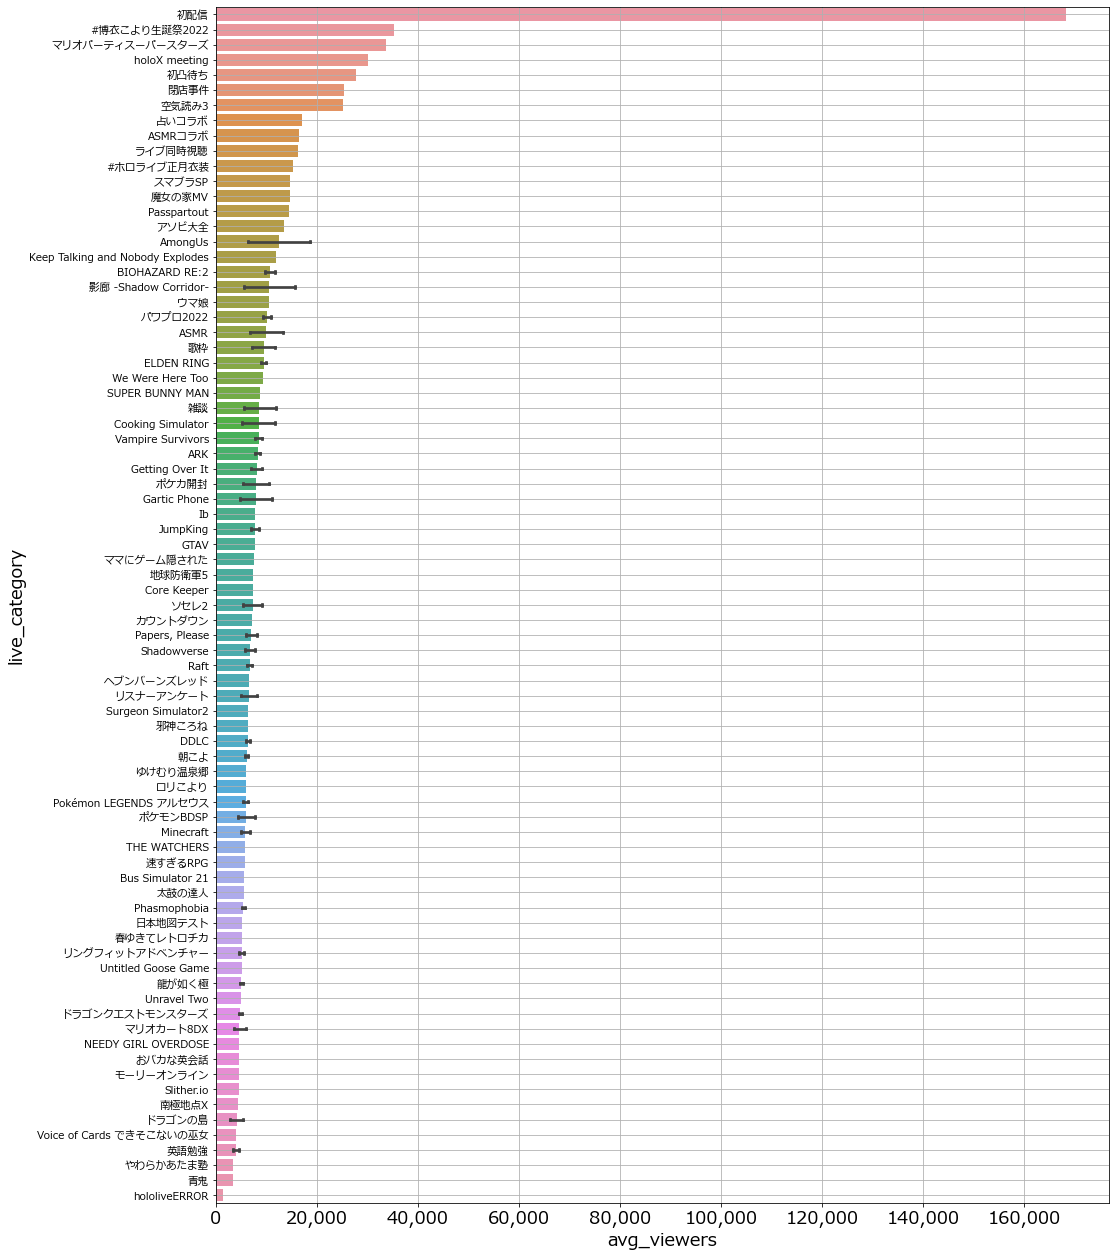

In [72]:
fig, ax = plt.subplots(1, 1, figsize=(16, 22))
sns.barplot(
    data=df_merged,
    y='live_category',
    x='avg_viewers',
    ci=68, capsize=.1,
    ax=ax)
ax.tick_params('y', labelsize=10.5)
ax.grid(True)
set_sep3(ax, 'x')
plt.show()

In [72]:
df_time = df_for_agg.sort_values('start_datetime').copy()

In [73]:
first_datetime = '2021/11/28 21:00:00'
last_datetime = '2022/05/07 00:00:00'

In [74]:
df_time['hour'] = df_time['start_datetime'].dt.hour
df_time['minute'] = df_time['start_datetime'].dt.minute

In [75]:
df_time['start_datetime_sec0'] = df_time.apply(
    lambda x: datetime.datetime.strptime(f"{x['start_datetime'].year}-{x['start_datetime'].month}-{x['start_datetime'].day} {x['start_datetime'].hour}:{x['start_datetime'].minute}", '%Y-%m-%d %H:%M')
    , axis=1)

df_time['end_datetime_sec0'] = df_time.apply(
    lambda x: datetime.datetime.strptime(f"{x['end_datetime'].year}-{x['end_datetime'].month}-{x['end_datetime'].day} {x['end_datetime'].hour}:{x['end_datetime'].minute}", '%Y-%m-%d %H:%M')
    , axis=1)

In [76]:
df_time.head(1)

,video_id,scheduled_start_datetime,start_datetime,end_datetime,duration,title,live_category,live_category_sub,year,month,day,year_month,view_count,like_count,favorite_count,comment_count,hour,minute,start_datetime_sec0,end_datetime_sec0
237,r3Ba-2Y5HDY,2021-11-28 21:00:00,2021-11-28 21:00:19,2021-11-28 22:00:32,3613.0,【初配信】スタートまでにTwitterの凍結は溶けるのか！？RTA開始！ふぁいっ！【博衣こよ...,初配信,博衣こより/ホロライブ,2021,11,28,2021-11,1544335.0,100703.0,0.0,1595.0,21,0,2021-11-28 21:00:00,2021-11-28 22:00:00


In [77]:
col_start_dt_index = list(df_time.columns).index('start_datetime_sec0')
col_end_dt_index = list(df_time.columns).index('end_datetime_sec0')

In [78]:
df_is_live = pd.DataFrame(
    index=pd.date_range(start=pd.to_datetime(first_datetime), end=pd.to_datetime(last_datetime), freq='1min'),
    columns=['is_live']
).fillna(0)

for i in range(len(df_for_agg)):
    idx = pd.date_range(
        start=df_time.iloc[i,col_start_dt_index], 
        end=df_time.iloc[i, col_end_dt_index],
        freq='1min'
    )
    idx = idx[np.where(idx<=last_datetime)[0]]
    
    df_is_live.loc[idx, 'is_live'] += 1

In [79]:
df_is_live = df_is_live.reset_index().rename(columns={'index':'datetime'})

In [80]:
df_is_live['minutes'] = df_is_live['datetime'].dt.hour*60 + df_is_live['datetime'].dt.minute
df_is_live['hours'] = (df_is_live['datetime'].dt.hour*60 + df_is_live['datetime'].dt.minute) / 60

月曜=0、日曜=6の曜日。

In [81]:
df_is_live['weekday'] = df_is_live['datetime'].dt.weekday

In [82]:
df_is_live['dow'] = df_is_live['weekday'].replace({0:'月', 1:'火', 2:'水', 3:'木', 4:'金', 5:'土', 6:'日'})

In [83]:
df_is_live = df_is_live.groupby(['weekday', 'dow', 'minutes', 'hours'])['is_live'].sum().to_frame('count').reset_index()

In [84]:
df_0 = df_is_live[df_is_live['weekday']==0].rename(columns={'count':'月'})
df_1 = df_is_live[df_is_live['weekday']==1].rename(columns={'count':'火'})
df_2 = df_is_live[df_is_live['weekday']==2].rename(columns={'count':'水'})
df_3 = df_is_live[df_is_live['weekday']==3].rename(columns={'count':'木'})
df_4 = df_is_live[df_is_live['weekday']==4].rename(columns={'count':'金'})
df_5 = df_is_live[df_is_live['weekday']==5].rename(columns={'count':'土'})
df_6 = df_is_live[df_is_live['weekday']==6].rename(columns={'count':'日'})

In [85]:
df_weekday = df_0[['minutes', 'hours', '月']].copy()
df_weekday = pd.merge(df_weekday, df_1[['minutes', 'hours', '火']])
df_weekday = pd.merge(df_weekday, df_2[['minutes', 'hours', '水']])
df_weekday = pd.merge(df_weekday, df_3[['minutes', 'hours', '木']])
df_weekday = pd.merge(df_weekday, df_4[['minutes', 'hours', '金']])
df_weekday = pd.merge(df_weekday, df_5[['minutes', 'hours', '土']])
df_weekday = pd.merge(df_weekday, df_6[['minutes', 'hours', '日']])

In [86]:
df_weekday_view = df_weekday.copy()

In [87]:
df_weekday_view = pd.concat(
    [
        df_weekday_view[df_weekday_view['hours']>=6],
        df_weekday_view[df_weekday_view['hours']<6],
    ],axis=0
)
df_weekday_view = df_weekday_view.reset_index(drop=True)

In [88]:
s_monday = df_weekday_view.loc[df_weekday_view['hours']<6, '月']
df_weekday_view.loc[df_weekday_view['hours']<6, '月'] = df_weekday_view.loc[df_weekday_view['hours']<6, '火']
df_weekday_view.loc[df_weekday_view['hours']<6, '火'] = df_weekday_view.loc[df_weekday_view['hours']<6, '水']
df_weekday_view.loc[df_weekday_view['hours']<6, '水'] = df_weekday_view.loc[df_weekday_view['hours']<6, '木']
df_weekday_view.loc[df_weekday_view['hours']<6, '木'] = df_weekday_view.loc[df_weekday_view['hours']<6, '金']
df_weekday_view.loc[df_weekday_view['hours']<6, '金'] = df_weekday_view.loc[df_weekday_view['hours']<6, '土']
df_weekday_view.loc[df_weekday_view['hours']<6, '土'] = df_weekday_view.loc[df_weekday_view['hours']<6, '日']
df_weekday_view.loc[df_weekday_view['hours']<6, '日'] = s_monday

In [89]:
df_weekday_view = df_weekday_view.set_index('hours')[['月', '火', '水', '木', '金', '土', '日']]

In [90]:
df_weekday_norm_view = df_weekday_view.copy()

In [91]:
df_weekday_norm_view[['月', '火', '水', '木', '金', '土', '日']] = (
    df_weekday_norm_view[['月', '火', '水', '木', '金', '土', '日']] / df_weekday_norm_view[['月', '火', '水', '木', '金', '土', '日']].sum(axis=0)
)

In [92]:
import matplotlib.dates as mdates

In [93]:
duration_days = (df_time['start_datetime'].max() - df_time['start_datetime'].min()).days /7

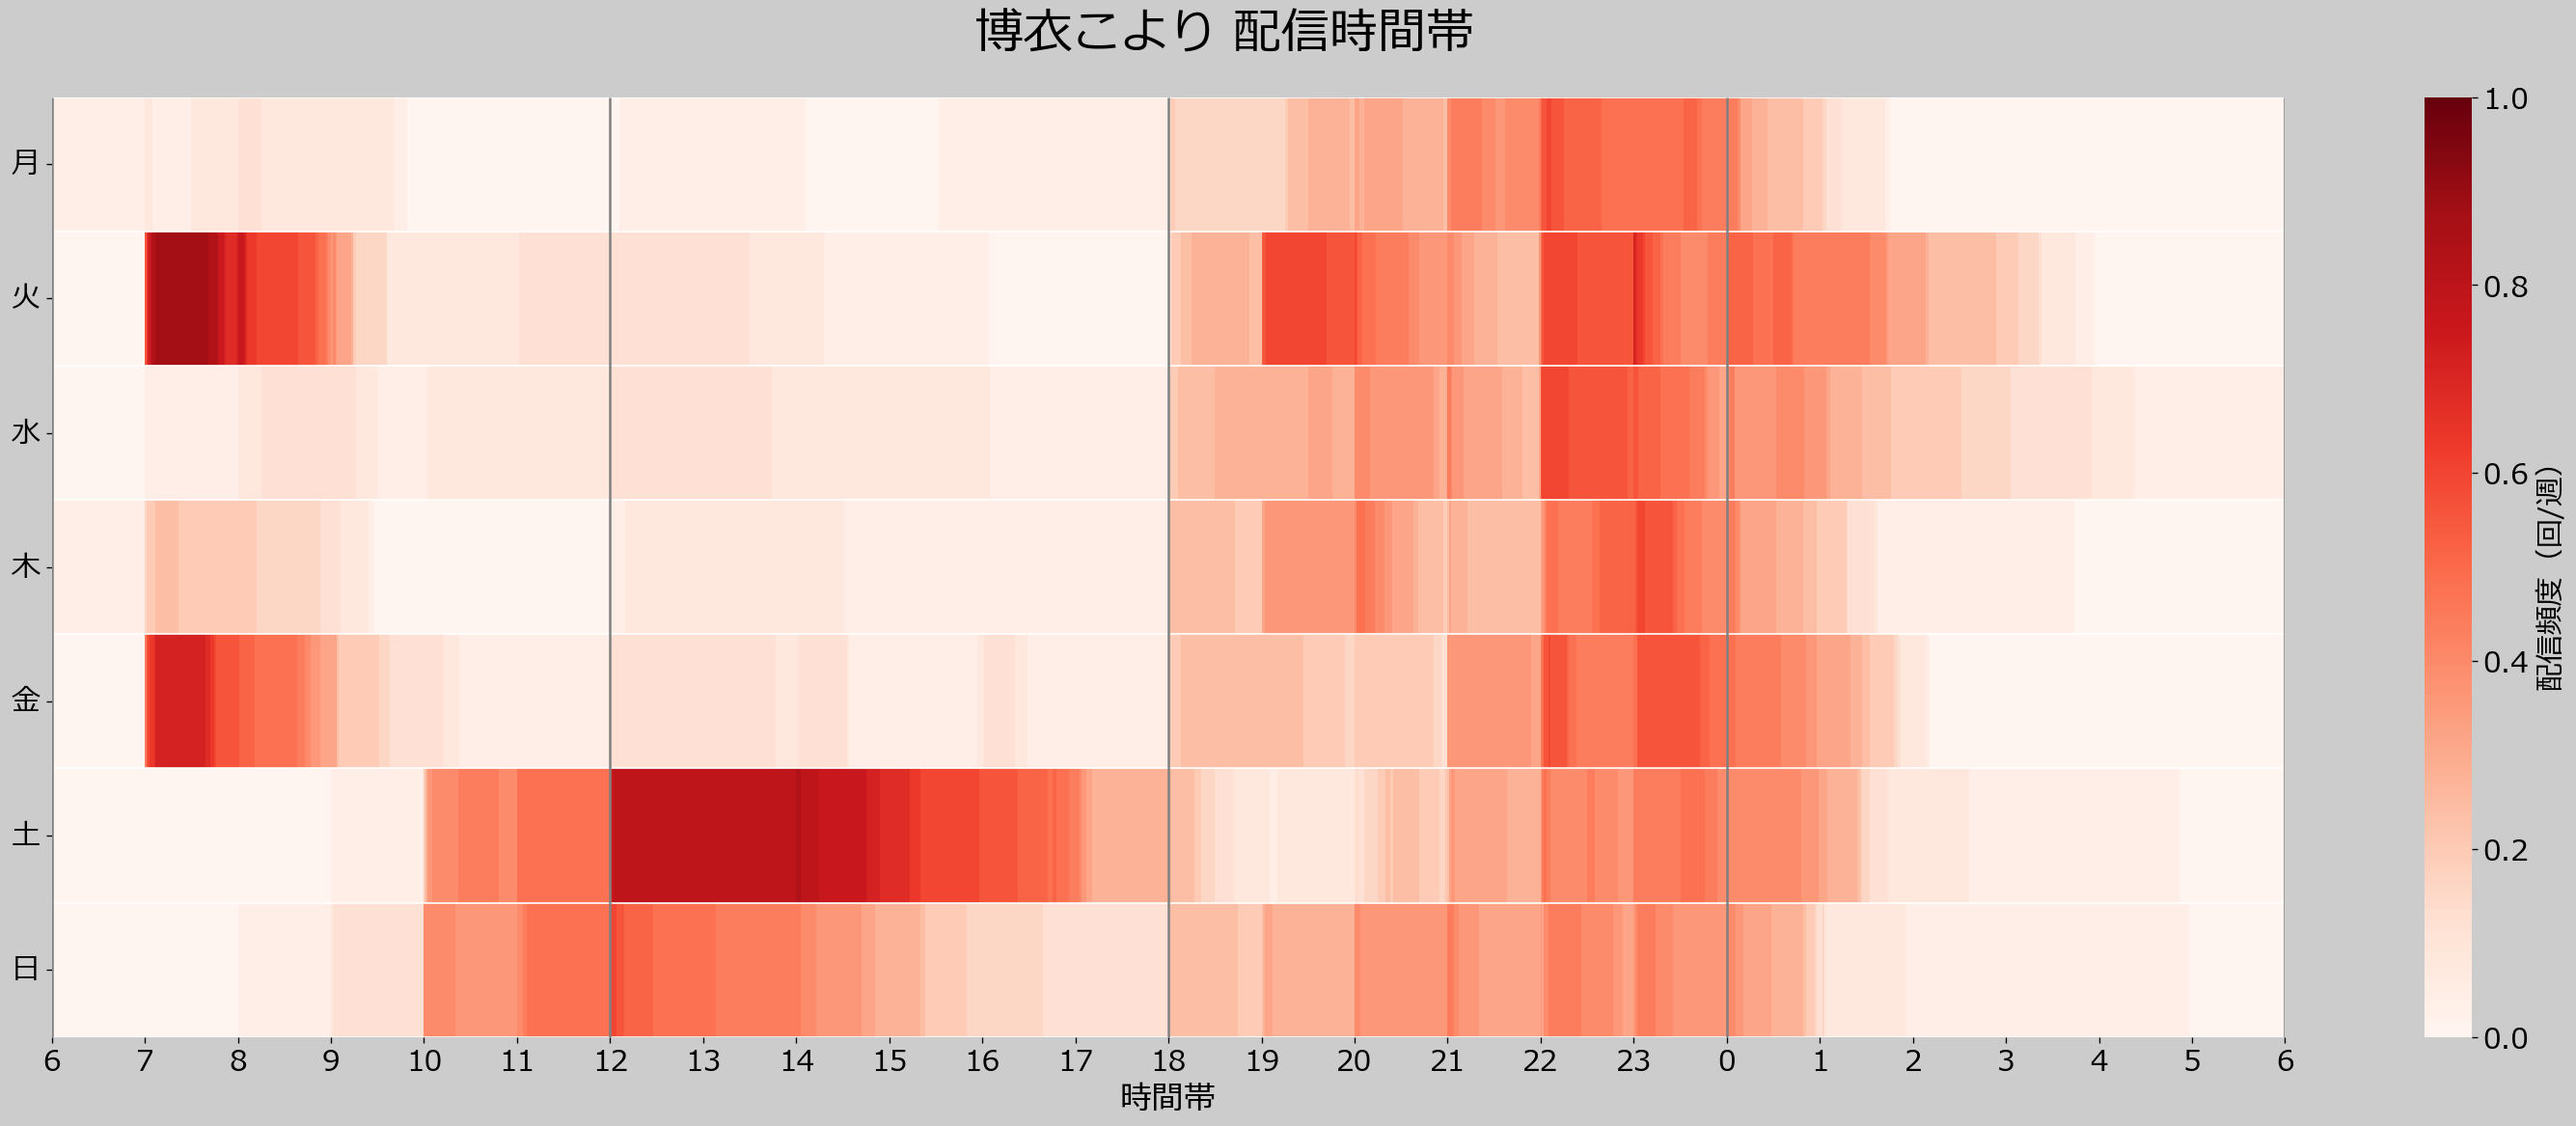

In [94]:
fig, ax = plt.subplots(1,1, figsize=(25, 10), dpi=120)
sns.heatmap(
    df_weekday_view.T / duration_days, 
    cmap='Reds',
    cbar=True,
    vmin=0, vmax=1,
    cbar_kws={'label': '配信頻度（回/週）'})

ax.set_xticks([i for i in np.arange(0, 1440, 60)] + [1440]);
xticklabels = [f'{h:.0f}' for h in df_weekday_view.index[::60]] + ['6']
ax.set_xticklabels(xticklabels);
ax.tick_params(axis='x', labelrotation=0);
ax.tick_params(axis='y', labelrotation=0);

ax.hlines(np.arange(43), *ax.get_xlim(), color='white',linewidth =1)

ax.vlines([0, 6*60, 12*60, 18*60, 24*60], *ax.get_ylim(), color='gray')
ax.set_xlabel('時間帯', fontsize=20)

    
fig.patch.set_facecolor((0.8, 0.8, .8))
# ax.set_title('博衣こより 配信時間帯', fontsize=30)
fig.suptitle('博衣こより 配信時間帯', fontsize=30, x=0.43)
fig.tight_layout(rect=[0,0,1,1.01])
plt.show()

fig.savefig('配信時間帯.png',bbox_inches='tight',pad_inches=0.05)
